In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import gstools as gs

pd.set_option('display.max_columns', None)

/home/arvinder/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def get_dataframe(data_path, latlon_path):
    # Initialize an empty dictionary to store dataframes and a list for site names
    data_dict = {}
    start_date = '1980-01-01'
    end_date = '2023-12-31'
    common_index = pd.date_range(start=start_date, end=end_date)
    site_name = []

    # Iterate through each gauge directory in data_path
    for gauge in data_path:
        # Iterate through each file in the current gauge directory
        for file_name in os.listdir(gauge):
            # Append the file name to site_name list
            site_name.append(file_name.split(".xlsx")[0])
            file = os.path.join(gauge, file_name)
            
            # Read the Excel file into a dataframe
            df = pd.read_excel(file)
            
            # Check if the dataframe contains a "Date" column
            if "Date" in df.columns:
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Read latitude and longitude data from latlon_path
                lat_lon_df = pd.read_excel(latlon_path)
                lat_lon_df.set_index("site_number", inplace=True)
                
                # Extract site number from the file name
                site_number = int(file_name.split("_")[0])
                
                # Get latitude and longitude for the current site number
                lat_lon = lat_lon_df.loc[site_number]
                latitude = float(lat_lon["Lat"])
                longitude = float(lat_lon["Long_"])
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
            else:
                # Rename columns if the dataframe does not have a "Date" column
                df.rename(columns={'DATE': 'Date', 'PRCP': 'Daily Rain (inches)', 'PRCP (in)': 'Daily Rain (inches)'}, inplace=True)
                
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Extract latitude and longitude from the first row
                lat_lon = df.iloc[0]
                latitude = float(lat_lon["LATITUDE"])
                longitude = float(lat_lon["LONGITUDE"])
                
                # Drop unnecessary columns
                columns_to_delete = df.columns[:5]
                df.drop(columns=columns_to_delete, inplace=True)
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
    
    # Return the dictionary of dataframes and the list of site names
    return data_dict, site_name


In [4]:
prcp_path_hydromet = "/home/arvinder/interpolation/Precipitation/Hydromet"
hydromet_latlon_path = "/home/arvinder/interpolation/Precipitation/Hydromet Gage LatLong.xls"

prcp_path_NOAA = "/home/arvinder/interpolation/Precipitation/NOAA"
NOAA_latlon_path = "/home/arvinder/interpolation/Precipitation/NOAA Gage LatLong.xlsx"
LCRA_shp_pth = "/home/arvinder/interpolation/HUC4_1209/HUC4_1209.shp"

# prcp_dict, site_names = get_dataframe([prcp_path_hydromet, prcp_path_NOAA], hydromet_latlon_path)
prcp_dict, site_names = get_dataframe([prcp_path_hydromet], hydromet_latlon_path)
prcp_coord = list(prcp_dict.keys())

In [ ]:
# Analyze data- Time distribution 

# Reindex dataframe with time indexing
all_df = prcp_dict.values()
all_df = [df.rename(columns={df.columns[0]: 'time'}) for df in all_df]
all_df = [df.set_index('time') for df in all_df]

# Drop nan values, Add (start, end) date to the list and then sort it on the basis of start date
start_end = []
for df in all_df:
    df =df.dropna()
    start_end.append((df.index.min(), df.index.max()))
start_end = sorted(start_end, key=lambda x: x[0])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

# Plot each interval as a horizontal bar
for i, (start, end) in enumerate(start_end):
    ax.barh(i, (end - start).days, left=start, height=0.4, align='center')


# Format the x-axis to show dates nicely
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set the major ticks to every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Set labels and title
ax.set_xlabel('Year')
ax.set_title('Time Intervals')

# Show the plot
plt.tight_layout()
plt.show()

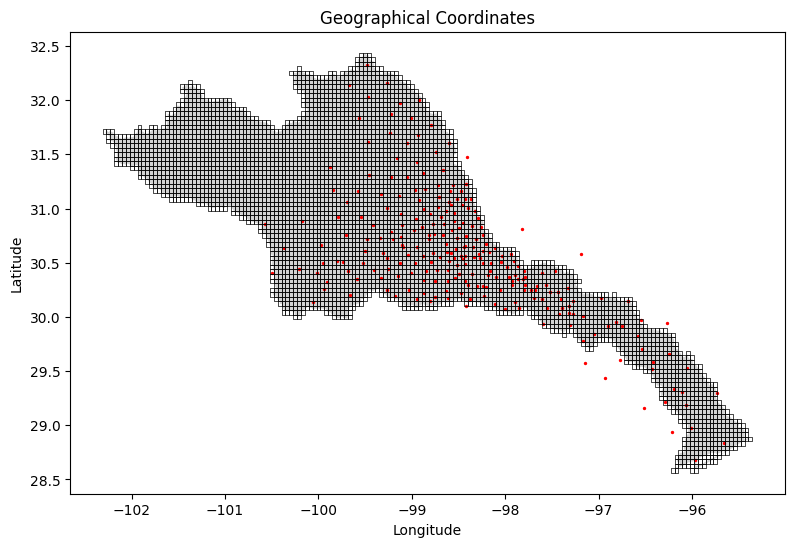

In [5]:
#Read and Reproject the world and grid map to EPSG:3857 (meters)
world = gpd.read_file(LCRA_shp_pth)
world = world.to_crs(epsg=3857)

mesh_grid = gpd.read_file("/home/arvinder/Downloads/prism_4km_mesh/prism_4km_mesh.shp")
mesh_grid = mesh_grid.to_crs(epsg=3857)

# Perform the intersection
intersected_mesh = gpd.sjoin(mesh_grid, world, how='inner', predicate='intersects')

# Reproject the world and grid map to EPSG:4326
intersected_mesh = intersected_mesh.to_crs(epsg=4326)
world = world.to_crs(epsg=4326)

#Plot world, mesh and prcp data
base = world.plot(color='lightgray', figsize=(10, 6))
intersected_mesh.boundary.plot(ax=base, edgecolor='black', linewidth=0.5)

prcp_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in prcp_coord], crs="EPSG:4326")
prcp_gdf.plot(ax=base, marker='o', color='red', markersize=2)

plt.title('Geographical Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [6]:
# Calculate the centroids using an equal-area projection
equal_area_crs = '+proj=cea'
intersected_mesh['centroid_equal_area'] = intersected_mesh.to_crs(equal_area_crs).centroid.to_crs(intersected_mesh.crs)

# Extract the coordinates of the centroids
centroid_equal_area = intersected_mesh['centroid_equal_area'].apply(lambda point: (point.x, point.y)).tolist()

# Extract x and y coordinates of centroids
centroid_coords = np.array(centroid_equal_area)

# Convert to numpy arrays
coords = np.array(list(prcp_dict.keys()))
values_orig = list(np.array(prcp_data['Daily Rain (inches)']) for prcp_data in prcp_dict.values())

In [48]:
x_coords = np.array(coords[:, 1])   #  Longitude
y_coords = np.array(coords[:, 0])   #  Latitude

# Create an array of dates between start and end date
start_date = '1980-01-01'
end_date = '2023-12-31'
dates = np.arange(start_date, end_date, dtype='datetime64[D]')
def init_kriging(dates, x_coords, y_coords, values_orig):
    i = 0
    interpolated_vals = []
    interpolated_var = []

    while i < len(dates):   #len(dates)

        values = np.array([array[i] for array in values_orig[:]])

        # Define a spatiotemporal variogram model
        model = gs.Exponential(dim=2, var=1.0, len_scale=0.9)

        # Create the kriging field
        krig = gs.krige.Krige(
            model, cond_pos=[x_coords, y_coords], cond_val=values
        )

        # Perform the kriging
        field, variance = krig((centroid_coords[:, 0], centroid_coords[:, 1]))
        field[field < 0] = 0
        interpolated_vals.append(field)
        interpolated_var.append(variance)
        i+=1
    return interpolated_vals, interpolated_var

In [20]:
def logNormal_kriging(dates, x_coords, y_coords, values_orig):
    i = 0
    interpolated_vals = []
    interpolated_var = []

    while i < len(dates):   #len(dates)

        values = np.array([array[i] for array in values_orig[:]])

        # Define a spatiotemporal variogram model
        model = gs.Exponential(dim=2, var=1.0, len_scale=0.9)
        normalizer = gs.normalizer.LogNormal

        # Create the kriging field
        krig = gs.krige.Krige(
            model, cond_pos=[x_coords, y_coords], cond_val=values, normalizer=normalizer)

        # Perform the kriging
        field, variance = krig((centroid_coords[:, 0], centroid_coords[:, 1]))
        field = np.exp(field) - 1
        field[field < 0] = 0
        interpolated_vals.append(field)
        interpolated_var.append(variance)
        i+=1
    return interpolated_vals, interpolated_var

In [49]:
interpolated_vals, interpolated_var = init_kriging(dates, x_coords, y_coords, values_orig)

In [42]:
for arr in interpolated_vals:
    if np.max(arr) > 0:
        print(np.max(arr))

1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.718281828459045
1.71828182

In [ ]:
for i in range(len(interpolated_vals)):
    raster_data = {
    "latitude": centroid_coords[:, 1],
    "longitude": centroid_coords[:, 0],
    "value": interpolated_vals[98]
    }

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(raster_data, geometry=gpd.points_from_xy(raster_data['longitude'], raster_data['latitude']))

    # Define the grid resolution (4km x 4km)
    grid_size = 0.041666666667  # 4km in degrees

    # Define the bounds of the raster
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int(np.ceil((maxx - minx) / grid_size))
    height = int(np.ceil((maxy - miny) / grid_size))

    # Create an empty raster
    raster = np.full((height, width), np.nan, dtype=np.float32)  # Initialize with NaNs to identify empty cells

    # Calculate the transform
    transform = from_origin(minx, maxy, grid_size, grid_size)
    crs = CRS.from_epsg(4326)  # Assuming WGS84

    # Fill the raster with values
    for _, row in gdf.iterrows():
        rowx = int((row.geometry.x - minx) / grid_size)
        rowy = int((maxy - row.geometry.y) / grid_size)
        if 0 <= rowx < width and 0 <= rowy < height:  # Ensure indices are within bounds
            if np.isnan(raster[rowy, rowx]):
                raster[rowy, rowx] = row['value']
            else:
                # Handle multiple points in the same cell; here we take the average
                raster[rowy, rowx] = (raster[rowy, rowx] + row['value']) / 2
        else:
            print("Out of bounds")
        

    # Define the output raster file
    output_file = 'output'+ str(i) + '.tif'

    # Write the raster to a file
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,  # WGS84 Latitude/Longitude
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

    break

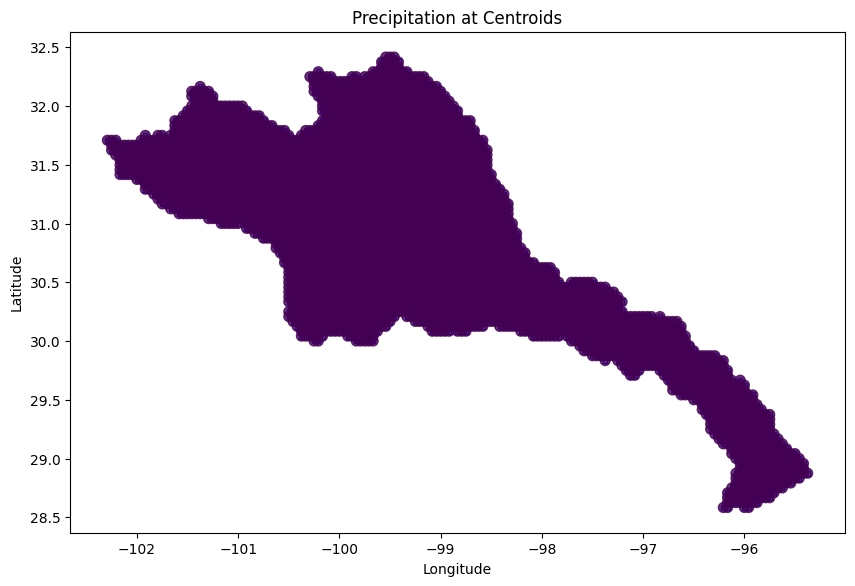

In [34]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
intersected_mesh.plot(ax=ax, facecolor='none', edgecolor='blue')  # Plot the original geometries for reference

day_to_plt = 98  # Which day to plot 

# Plot centroids with color representing precipitation values
ax.scatter(centroid_coords[:, 0], centroid_coords[:, 1], c=interpolated_vals[day_to_plt], cmap='viridis', s=50, alpha=0.8, vmin=0)
plt.title('Precipitation at Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [50]:
from geopy.distance import geodesic

# Validation

#  generate random array
random_arr = np.random.randint(len(x_coords) - 1, size=(len(x_coords)//5))

# Empty list to store random gauges
random_x_coords = []
random_y_coords = []
random_values = []

# adding long/lat and values info to the empty list
for random_num in random_arr:
    random_x_coords.append(x_coords[random_num])
    random_y_coords.append(y_coords[random_num])
    random_values.append(values_orig[random_num])

# Create three new lists, excluding the elements at the specified indexes
new_x_coords = [item for idx, item in enumerate(x_coords) if idx not in random_arr]
new_y_coords = [item for idx, item in enumerate(y_coords) if idx not in random_arr]
new_values = [item for idx, item in enumerate(values_orig) if idx not in random_arr]

# Perform Kriging and store new interpolated vals
new_interpolated_vals, new_interpolated_vars = init_kriging(dates, new_x_coords, new_y_coords, new_values)

In [51]:
def find_closest_point(given_latlon, lat_list, lon_list):
    closest_point_id = None
    min_distance = float('inf')
    
    for loc_id, (lat, lon) in enumerate(zip(lat_list, lon_list)):
        point = (lat, lon)
        distance = geodesic(given_latlon, point).kilometers
        if distance < min_distance:
            min_distance = distance
            closest_point_id = loc_id    

    return closest_point_id

closest_points = []
for i in range(len(random_x_coords)):
    clst_pt = find_closest_point((random_y_coords[i], random_x_coords[i]), centroid_coords[:, 1], centroid_coords[:, 0])
    closest_points.append(clst_pt)
    

In [52]:
from sklearn.metrics import r2_score, mean_absolute_error
i = 0
new_vals = np.vstack(new_interpolated_vals)
r_sq_list = []
mae_list = []
for ran_val in random_values:
    observed = ran_val[:-1]
    predicted = new_vals[:, closest_points[i]]

    # Filter out NaN values
    valid_mask = ~np.isnan(observed)
    observed_filtered = observed[valid_mask]
    predicted_filtered = predicted[valid_mask]
    i += 1
    r_squared = r2_score(observed_filtered, predicted_filtered)
    mae = mean_absolute_error(observed_filtered, predicted_filtered)
    # print(f"R-squared: {r_squared:.9f}")
    r_sq_list.append(r_squared)
    mae_list.append(mae * 25.4)    # inch to mm


In [53]:
num_val_stations = len(r_sq_list)
median_r_sqr = np.median(r_sq_list)
mean_r_sqr = np.mean(r_sq_list)

median_mae = np.median(mae_list)
mean_mae = np.mean(mae_list)

count = 0
threshold = 0.7

for r_sq in r_sq_list:
    if r_sq > threshold:
        count += 1

num_above_threshold = count/num_val_stations

print(f"Number of weather stations in validation: {num_val_stations}")
print(f"Median R square: {median_r_sqr}")
print(f"Mean R square: {mean_r_sqr}")
print(f"Median MAE (mm/day): {median_mae}")
print(f"Mean MAE (mm/day): {mean_mae}")
print(f"No. of stations above 0.7 R-squared: {num_above_threshold}")

Number of weather stations in validation: 49
Median R square: 0.8009790504453974
Mean R square: 0.7814954547364575
Median MAE (mm/day): 0.8394344156894964
Mean MAE (mm/day): 0.8804489366527595
No. of stations above 0.7 R-squared: 0.8367346938775511


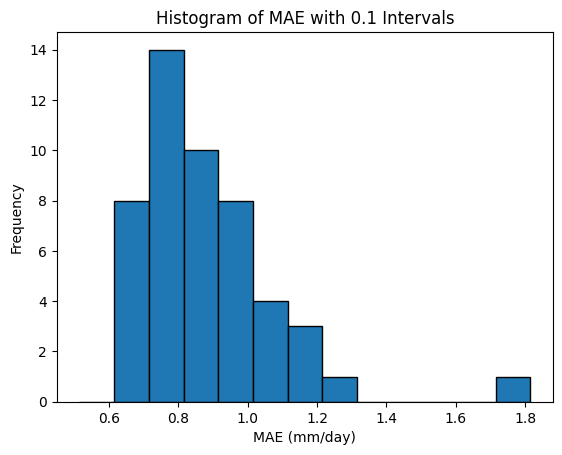

In [54]:
interval = 0.1
bin_edges = np.arange(min(mae_list) - interval, max(mae_list) + interval, interval)

# Create histogram
plt.hist(mae_list, bins=bin_edges, edgecolor='black')

# Add labels and title
plt.xlabel('MAE (mm/day)')
plt.ylabel('Frequency')
plt.title(f'Histogram of MAE with {interval} Intervals')

# Show plot
plt.show()

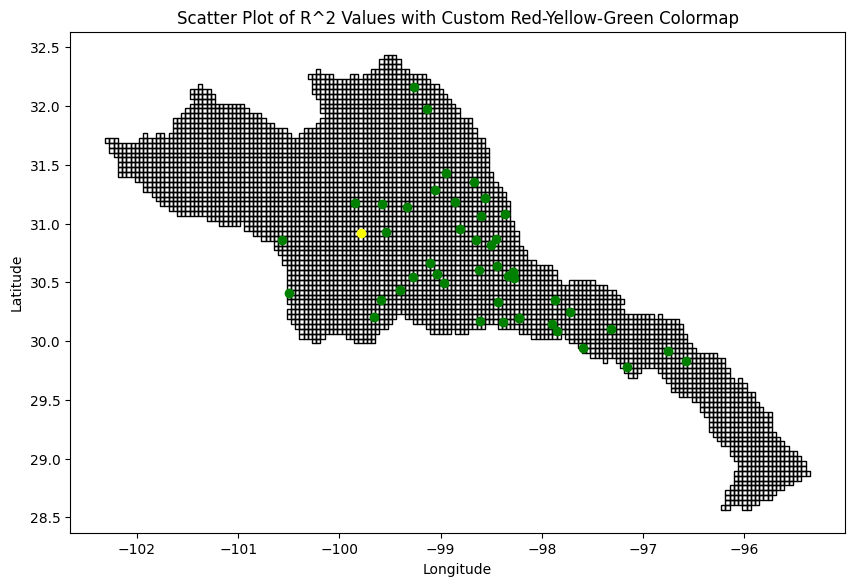

In [55]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
intersected_mesh.plot(ax=ax, facecolor='none', edgecolor='black')  # Plot the original geometries for reference

for idx, r_sw in enumerate(r_sq_list):
    if r_sw > 0.5:
        # Create the scatter plot
        ax.scatter(random_x_coords[idx], random_y_coords[idx], color="green")
    if 0.3 < r_sw <= 0.5:
        # Create the scatter plot
        ax.scatter(random_x_coords[idx], random_y_coords[idx], color="yellow")
    if 0.3 >= r_sw :
        # Create the scatter plot
        ax.scatter(random_x_coords[idx], random_y_coords[idx], color="red")
    if r_sw < 0:
        ax.scatter(random_x_coords[idx], random_y_coords[idx], color="Black")

plt.title('Scatter Plot of R^2 Values with Custom Red-Yellow-Green Colormap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [56]:
prcp_dict_NOAA, site_names_NOAA = get_dataframe([prcp_path_NOAA], hydromet_latlon_path)

prcp_coord_NOAA = list(prcp_dict_NOAA.keys())

In [57]:
lon_hydromet = np.array(prcp_coord)[:, 1]
lat_hydromet = np.array(prcp_coord)[:, 0]

closest_points_vali = []
for i in range(len(prcp_coord_NOAA)):
    clst_pt = find_closest_point(prcp_coord_NOAA[i], lat_hydromet, lon_hydromet)
    closest_points_vali.append(clst_pt)
    
for k, c in enumerate(closest_points_vali):
    print(f"NOAA Coordinate: {prcp_coord_NOAA[k]}, Closest Hydromet Coordinate: {prcp_coord[c]}")

NOAA Coordinate: (29.96667, -97.45), Closest Hydromet Coordinate: (30.02875, -97.42613)
NOAA Coordinate: (30.74765, -99.23067), Closest Hydromet Coordinate: (30.78697, -99.22088)
NOAA Coordinate: (30.2533, -98.5711), Closest Hydromet Coordinate: (30.240741, -98.63287)
NOAA Coordinate: (31.35172, -100.4948), Closest Hydromet Coordinate: (30.85725, -100.56887)
NOAA Coordinate: (28.7248, -96.25353), Closest Hydromet Coordinate: (28.93837, -96.2116)
NOAA Coordinate: (31.4405, -98.5902), Closest Hydromet Coordinate: (31.3527, -98.6712)
NOAA Coordinate: (31.82795, -99.41777), Closest Hydromet Coordinate: (31.832923, -99.560904)
NOAA Coordinate: (29.1573, -95.4593), Closest Hydromet Coordinate: (29.3008, -95.7374)
NOAA Coordinate: (31.2841, -98.7588), Closest Hydromet Coordinate: (31.21389, -98.71974)
NOAA Coordinate: (29.9176, -96.8769), Closest Hydromet Coordinate: (29.91251, -96.89694)
NOAA Coordinate: (31.8983, -98.6033), Closest Hydromet Coordinate: (31.77069, -98.79734)
NOAA Coordinate:

246


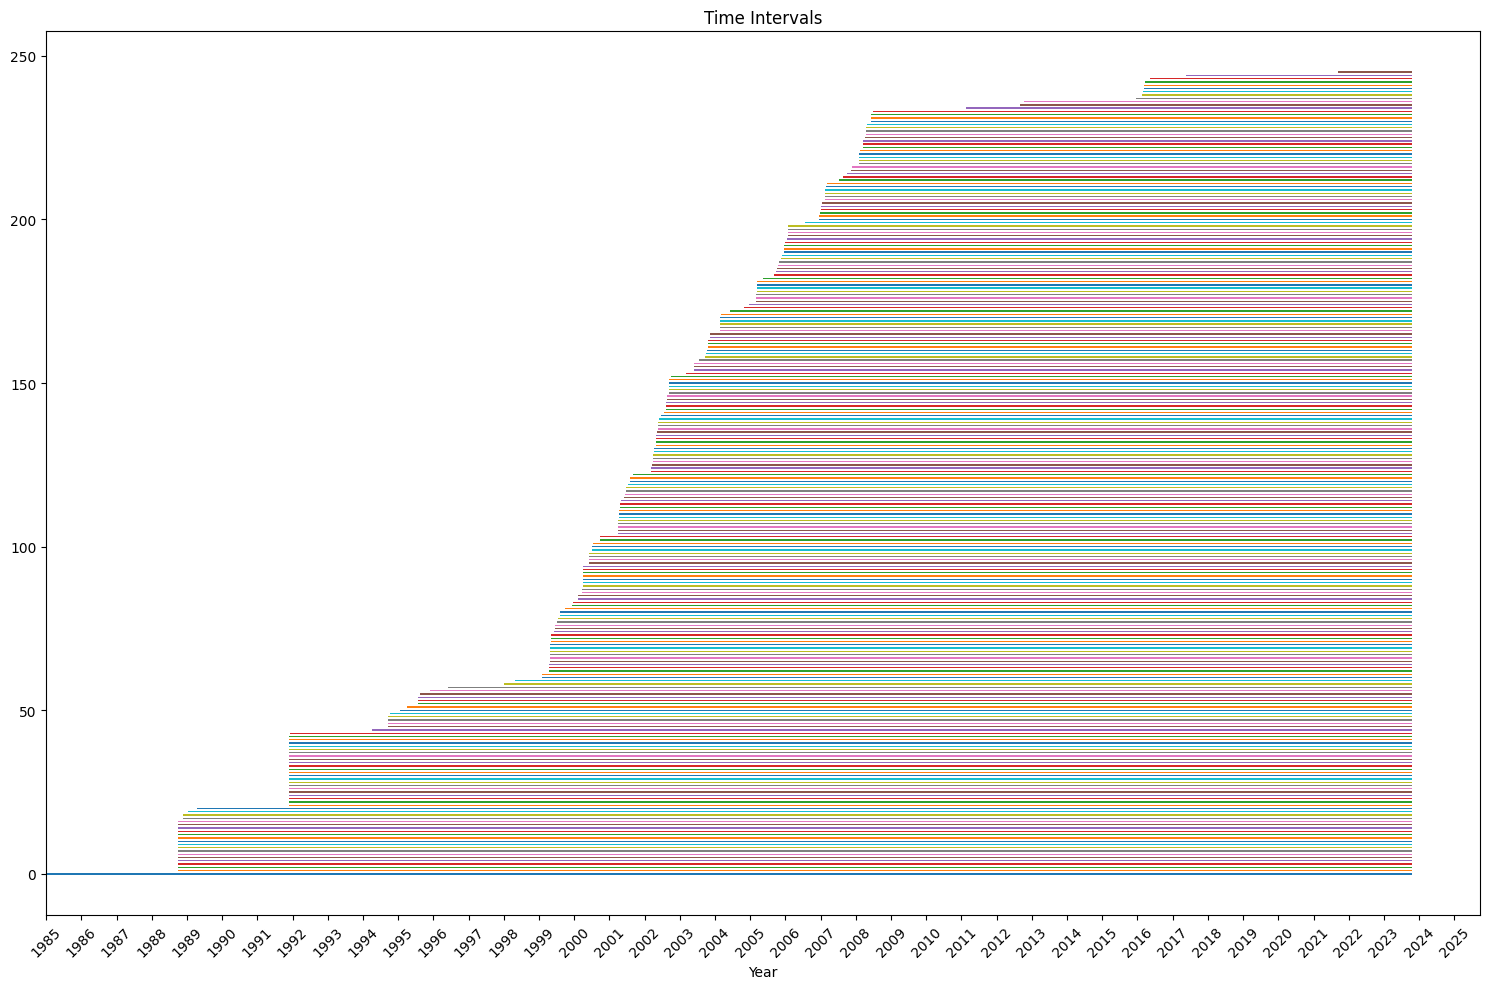